# Assembling the Shepherd simulation graph

This notebook contains a "literate programming" style overview of the code that assembles the Shepherd simulation graph.

In [1]:
%matplotlib widget

import random
from itertools import combinations, product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

## Overview

The Shepherd simulation graph contains three kinds of nodes.

- User nodes, which represent users of Flock
- Tag nodes, which represent tags in Flock
- Content nodes, which represent content in Flock

Below are various parameters which control the amounts of each, as well as the code that assembles lists of them and adds them to the graph:

In [2]:
plt.rcParams["figure.figsize"] = [12, 8]

G = nx.Graph()

n_users = 20
n_tags = 100
n_tag_groups = 25
n_content = 500

users = [f"user-{i}" for i in range(n_users)]
tags = [f"tag-{i}" for i in range(n_tags)]
content = [f"content-{i}" for i in range(n_content)]

G.add_nodes_from(users, node_type="user", color="#ffb8b8")
G.add_nodes_from(tags, node_type="tags", color="#00eb00")
G.add_nodes_from(content, node_type="content", color="#c7c7ff")

It is important to note that the weights associated with edges on the graph represent the "closeness" of the nodes connected by the edge. This was chosen as it means that the sum of weights along the shortest path connecting a user node to a tag node can be used as an approximation of a user's interest in the content.

## Connecting to tags

First, we start by adding edges from users to tags and content to tags. An important thing to note is that neither content nor users can have edges among themselves (nor to each other); content and users can only have edges connecting them to tag nodes.

The following function builds these edges by taking in a list of source nodes and a list of target nodes, and the maximum number of edges a source node can have to target nodes. Then, for each source node, it selects an integer in the range $[1, \text{max\_edges}]$ to be the number of target nodes this source node is connected to, and for each target node, it assigns a weight in the range $[0.1, 1.0]$ to the edge connecting the source node to the target node.

In [3]:
def build_external_edges(source_nodes, target_nodes, max_edges=10):
    for source in source_nodes:
        num_edges = random.randint(1, max_edges)
        connected_tags = random.sample(target_nodes, min(num_edges, len(target_nodes)))
        for tag in connected_tags:
            weight = random.uniform(0.1, 1.0)
            G.add_edge(source, tag, weight=weight)

We then use the function to connect users to tags and content to tags. We increase the maximum number of edges allowed for users as it's more likely for a user to have broad interests than the number of categories a piece of content would belong to.

In [4]:
build_external_edges(users, tags, max_edges=20)
build_external_edges(content, tags)

## Tag groups

We start by building disjoint groups of tags, with each group containing roughly the same amount of tags, in which the average is determined by the number of tags available divided by the maximum number of groups plus one. This value is chosen such that there are usually some number of tags outside of a tag group.

In [5]:
def build_tag_groups(tags, max_groups):
    rng = np.random.default_rng()
    average_tags = len(tags) // (max_groups + 1)
    random.shuffle(tags)

    t = 0
    group_elements = []
    for _ in range(max_groups):
        n = rng.poisson(average_tags)
        if t + n >= len(tags):
            n = len(tags) - t
            if n == 0:
                break

        group_elements.append(tags[t : t + n])
        t += n

    return group_elements

Then, we add edges within nodes in a group. Unlike weights between tags and content or tags and users, weights between tags in a tag group are higher due to their presumed relatedness, and are thus constrained to the range $[0.5, 1.0]$.

In [6]:
tag_groups = build_tag_groups(tags, n_tag_groups)

for group in tag_groups:
    for a, b in combinations(group, 2):
        weight = random.uniform(0.5, 1.0)
        G.add_edge(a, b, weight=weight)

Finally, we add edges between nodes in different groups. These weights are lower, due to the presumed dissimilarity of tags across groups, and are thus constrained to the range $[0.1, 0.5]$. There is a 10% chance the edge will be added at all between nodes in different groups.

In [7]:
for group_a, group_b in combinations(tag_groups, 2):
    for a, b in product(group_a, group_b):
        if random.random() <= 0.1:
            weight = random.uniform(0.1, 0.5)
            G.add_edge(a, b, weight=weight)

## Results

Here's a visualization of the resulting graph.

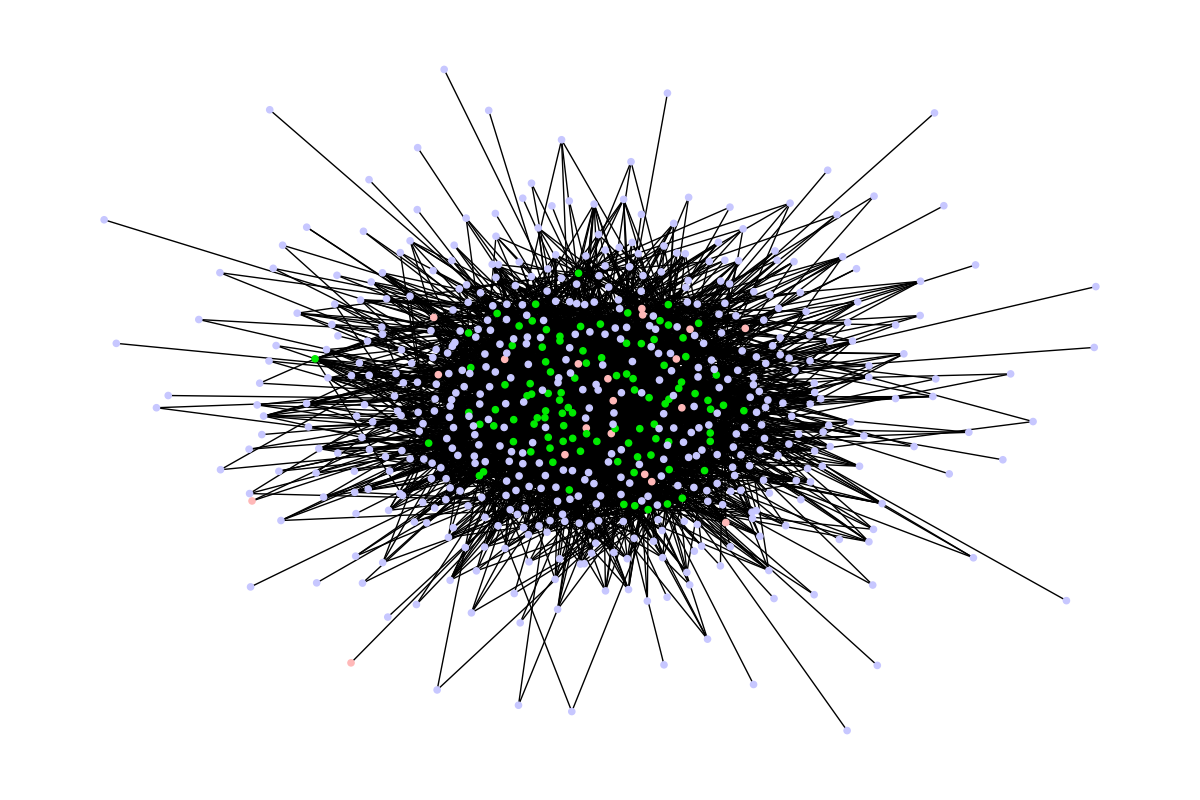

In [8]:
plt.clf()
nx.draw(
    G,
    pos=nx.kamada_kawai_layout(G),
    node_color=[n["color"] for _, n in G.nodes(data=True)],
    label="Shepherd graph",
    node_size=20,
)
plt.show()